# XAI for Generative Model on Landscape

In [1]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace
from torch.autograd import Variable

In [2]:
!pip install einops
!pip install transformers
!pip install ema_pytorch
!pip install accelerate
!pip install lime==0.1.1.37

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.0/276.0 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - \ done
  Created wheel for lime: filename=lime-0.1.1.37-py3-none-any.whl size=284290 sha256=c58fbad9f5c696d74d5a53e5d1a05756bb3bf2ec8893815b13b255751b88ead3
  Stored in directory: /root/.cache/pip/wheels/c0/48/6c/2437c474145e879ae415fdce78be1ea7dc7e81f7f26900c667
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=5cd4bd7e2b3e84bd5eea2ccc3ef24561c36980bf4e23bb7cb9aa2b09ba71f7c3
  Stored in directory: /root/.cache/pip/wheels/cd/17/e5/765d1a3112ff3978f70223502f6047e06c43a24d7c5f8ff95b
Successfully built lime progressbar
  Attempting uninstall: lime
    Found existing installation: lime 0.2.0.1
    Uninstalling lime-0.2.0.1:
      Successfully uninstalled lime-0.2.0.1


In [3]:
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam

import torchvision
from torchvision import transforms as T, utils

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from PIL import Image
from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator
import matplotlib.pyplot as plt
import os

torch.backends.cudnn.benchmark = True
torch.manual_seed(4096)

if torch.cuda.is_available():
    torch.cuda.manual_seed(4096)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
args = {
      'ckptpath': '/kaggle/input/generatedmodel/model', # chinese style landscape 
      #'ckptpath': '/kaggle/input/real-landscape-dm-model/model',
      'dataset_dir': '/kaggle/input/chinese-landscape-paintings/all_paintings/'
      #'dataset_dir': '/kaggle/input/landscape-pictures/' # real landscape dataset
}
args = argparse.Namespace(**args)

In [5]:
# helpers
def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def exists(x):
    return x is not None

def linear_beta_schedule(timesteps):
    """
    linear schedule, proposed in original ddpm paper
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def cycle(dl):
    while True:
        for data in dl:
            yield data

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def identity(t, *args, **kwargs):
    return t

In [6]:
# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)
    
def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1 = 2, p2 = 2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1)
    )

In [7]:
# sinusoidal positional embeds

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    
    
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, 'o ... -> o 1 1 1', 'mean')
        var = reduce(weight, 'o ... -> o 1 1 1', partial(torch.var, unbiased = False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

# small helper modules

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
    
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)
    
class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)
    
    
class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g
    
    
class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q * self.scale

        sim = torch.einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = torch.einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)


In [8]:
class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        model,
        *,
        image_size,
        timesteps = 1000,
        beta_schedule = 'linear',
        auto_normalize = True
    ):
        super().__init__()
        assert not (type(self) == GaussianDiffusion and model.channels != model.out_dim)
        assert not model.random_or_learned_sinusoidal_cond

        self.model = model

        self.channels = self.model.channels

        self.image_size = image_size


        if beta_schedule == 'linear':
            beta_schedule_fn = linear_beta_schedule
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')

        # calculate beta and other precalculated parameters
        betas = beta_schedule_fn(timesteps)

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        # sampling related parameters

        self.sampling_timesteps = timesteps # default num sampling timesteps to number of timesteps at training

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # derive loss weight
        # snr - signal noise ratio

        snr = alphas_cumprod / (1 - alphas_cumprod)

        # https://arxiv.org/abs/2303.09556

        maybe_clipped_snr = snr.clone()

        register_buffer('loss_weight', maybe_clipped_snr / snr)

        # auto-normalization of data [0, 1] -> [-1, 1] - can turn off by setting it to be False

        self.normalize = normalize_to_neg_one_to_one if auto_normalize else identity
        self.unnormalize = unnormalize_to_zero_to_one if auto_normalize else identity

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )


    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, clip_x_start = False, rederive_pred_noise = False):
        model_output = self.model(x, t)
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity

        pred_noise = model_output
        x_start = self.predict_start_from_noise(x, t, pred_noise)
        x_start = maybe_clip(x_start)

        if clip_x_start and rederive_pred_noise:
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        return pred_noise, x_start

    def p_mean_variance(self, x, t, clip_denoised = True):
        noise, x_start = self.model_predictions(x, t)

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.no_grad()
    def p_sample(self, x, t: int):
        b, *_, device = *x.shape, x.device
        batched_times = torch.full((b,), t, device = x.device, dtype = torch.long)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, clip_denoised = True)
        noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start

    @torch.no_grad()
    def p_sample_loop(self, shape, return_all_timesteps = False):
        batch, device = shape[0], self.betas.device

        img = torch.randn(shape, device = device)
        imgs = [img]

        x_start = None

        ###########################################
        ## TODO: plot the sampling process ##
        ###########################################
        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            img, x_start = self.p_sample(img, t)
            imgs.append(img)

        ret = img if not return_all_timesteps else torch.stack(imgs, dim = 1)

        ret = self.unnormalize(ret)
        return ret

    @torch.no_grad()
    def sample(self, batch_size = 16, return_all_timesteps = False):
        image_size, channels = self.image_size, self.channels
        sample_fn = self.p_sample_loop
        return sample_fn((batch_size, channels, image_size, image_size), return_all_timesteps = return_all_timesteps)


    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    @property
    def loss_fn(self):
        return F.mse_loss


    def p_losses(self, x_start, t, noise = None):
        b, c, h, w = x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # predict and take gradient step

        model_out = self.model(x, t)

        loss = self.loss_fn(model_out, noise, reduction = 'none')
        loss = reduce(loss, 'b ... -> b (...)', 'mean')

        loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, *args, **kwargs):
        b, c, h, w, device, img_size, = *img.shape, img.device, self.image_size
        assert h == img_size and w == img_size, f'height and width of image must be {img_size}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = self.normalize(img)
        return self.p_losses(img, t, *args, **kwargs)

In [9]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        resnet_block_groups = 8,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)


In [10]:
class Trainer(object):
    def __init__(
        self,
        diffusion_model,
        folder,
        *,
        train_batch_size = 16,
        gradient_accumulate_every = 1,
        train_lr = 1e-4,
        train_num_steps = 100000,
        ema_update_every = 10,
        ema_decay = 0.995,
        adam_betas = (0.9, 0.99),
        save_and_sample_every = 1000,
        num_samples = 25,
        results_folder = './results',
        split_batches = True,
        inception_block_idx = 2048
    ):
        super().__init__()

        # accelerator

        self.accelerator = Accelerator(
            split_batches = split_batches,
            mixed_precision = 'no'
        )


        # model

        self.model = diffusion_model
        self.channels = diffusion_model.channels

        # sampling and training hyperparameters

        assert has_int_squareroot(num_samples), 'number of samples must have an integer square root'
        self.num_samples = num_samples
        self.save_and_sample_every = save_and_sample_every

        self.batch_size = train_batch_size
        self.gradient_accumulate_every = gradient_accumulate_every

        self.train_num_steps = train_num_steps
        self.image_size = diffusion_model.image_size

        # dataset and dataloader

        self.ds = Dataset(folder, self.image_size)
        dl = DataLoader(self.ds, batch_size = train_batch_size, shuffle = True, pin_memory = True, num_workers = cpu_count())

        dl = self.accelerator.prepare(dl)
        self.dl = cycle(dl)

        # optimizer

        self.opt = Adam(diffusion_model.parameters(), lr = train_lr, betas = adam_betas)

        # for logging results in a folder periodically

        if self.accelerator.is_main_process:
            self.ema = EMA(diffusion_model, beta = ema_decay, update_every = ema_update_every)
            self.ema.to(self.device)

        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(exist_ok = True)

        # step counter state

        self.step = 0

        # prepare model, dataloader, optimizer with accelerator

        self.model, self.opt = self.accelerator.prepare(self.model, self.opt)

    @property
    def device(self):
        return self.accelerator.device

    def save(self, milestone):
        if not self.accelerator.is_local_main_process:
            return

        data = {
            'step': self.step,
            'model': self.accelerator.get_state_dict(self.model),
            'opt': self.opt.state_dict(),
            'ema': self.ema.state_dict(),
            'scaler': self.accelerator.scaler.state_dict() if exists(self.accelerator.scaler) else None,
        }

        torch.save(data, str(self.results_folder / f'model-{milestone}.pt'))

    def load(self, ckpt):
        accelerator = self.accelerator
        device = accelerator.device

        data = torch.load(ckpt, map_location=device)

        model = self.accelerator.unwrap_model(self.model)
        model.load_state_dict(data['model'])

        self.step = data['step']
        self.opt.load_state_dict(data['opt'])
        if self.accelerator.is_main_process:
            self.ema.load_state_dict(data["ema"])


        if exists(self.accelerator.scaler) and exists(data['scaler']):
            self.accelerator.scaler.load_state_dict(data['scaler'])


    def train(self):
        accelerator = self.accelerator
        device = accelerator.device

        with tqdm(initial = self.step, total = self.train_num_steps, disable = not accelerator.is_main_process) as pbar:

            while self.step < self.train_num_steps:

                total_loss = 0.

                for _ in range(self.gradient_accumulate_every):
                    data = next(self.dl).to(device)

                    with self.accelerator.autocast():
                        loss = self.model(data)
                        loss = loss / self.gradient_accumulate_every
                        total_loss += loss.item()

                    self.accelerator.backward(loss)

                accelerator.clip_grad_norm_(self.model.parameters(), 1.0)
                pbar.set_description(f'loss: {total_loss:.4f}')

                accelerator.wait_for_everyone()

                self.opt.step()
                self.opt.zero_grad()

                accelerator.wait_for_everyone()

                self.step += 1
                if accelerator.is_main_process:
                    self.ema.update()

                    if self.step != 0 and self.step % self.save_and_sample_every == 0:
                        self.ema.ema_model.eval()

                        with torch.no_grad():
                            milestone = self.step // self.save_and_sample_every
                            batches = num_to_groups(self.num_samples, self.batch_size)
                            all_images_list = list(map(lambda n: self.ema.ema_model.sample(batch_size=n), batches))

                        all_images = torch.cat(all_images_list, dim = 0)

                        utils.save_image(all_images, str(self.results_folder / f'sample-{milestone}.png'), nrow = int(math.sqrt(self.num_samples)))

                        self.save(milestone)

                pbar.update(1)

        accelerator.print('training complete')
        
        # save the trained model
        if not os.path.exists('./model'):
            os.mkdir('./model')
        with torch.no_grad():
            torch.save(self.model.state_dict(), './model/model')

            

    def inference(self, num=1000, n_iter=5, output_path='./submission'):
        if not os.path.exists(output_path):
            os.mkdir(output_path)
        with torch.no_grad():
            for i in range(n_iter):
                batches = num_to_groups(num // n_iter, 200)
                all_images = list(map(lambda n: self.ema.ema_model.sample(batch_size=n), batches))[0]
                for j in range(all_images.size(0)):
                    torchvision.utils.save_image(all_images[j], f'{output_path}/{i * 200 + j + 1}.jpg')

In [11]:
# Load trained model

IMG_SIZE = 64             # Size of images, do not change this if you do not know why you need to change
batch_size = 16
train_num_steps = 100000 #10000        # total training steps
lr = 1e-3
grad_steps = 1            # gradient accumulation steps, the equivalent batch size for updating equals to batch_size * grad_steps = 16 * 1
ema_decay = 0.995           # exponential moving average decay

channels = 16             # Numbers of channels of the first layer of CNN
dim_mults = (1, 2, 4)        # The model size will be (channels, 2 * channels, 4 * channels, 4 * channels, 2 * channels, channels)

timesteps = 100            # Number of steps (adding noise)
beta_schedule = 'linear'

model = Unet(
    dim = channels,
    dim_mults = dim_mults
).cuda()

diffusion = GaussianDiffusion(
    model,
    image_size = IMG_SIZE,
    timesteps = timesteps,
    beta_schedule = beta_schedule
).cuda()

In [12]:
class Dataset(Dataset):
    def __init__(
        self,
        folder,
        image_size
    ):
        self.folder = folder
        self.image_size = image_size
        self.paths = [p for p in Path(f'{folder}').glob(f'**/*.jpg')]
        #################################
        ## TODO: Data Augmentation ##
        #################################
        self.transform = T.Compose([
            T.Resize(size=(image_size,image_size)),
            torchvision.transforms.Grayscale(num_output_channels=3),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        return self.transform(img)
    
    # help to get images for visualizing
    def getbatch(self, indices):
        images = []
        for index in indices:
            image = self.__getitem__(index)
            images.append(image)
        return torch.stack(images)

In [13]:
trainer = Trainer(
    diffusion,
    args.dataset_dir,
    train_batch_size = batch_size,
    train_lr = lr,
    train_num_steps = train_num_steps,
    gradient_accumulate_every = grad_steps,
    ema_decay = ema_decay,
    save_and_sample_every = 1000
)


In [14]:
trainer.load('/kaggle/input/model-100/model-100.pt')
#trainer.load('/kaggle/input/real-landscaoe-dm-model-100/model-100.pt')
trainer.inference(num=1, n_iter=1, output_path='./xai')

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
# diffusion.load_state_dict(torch.load(args.ckptpath))

## Dataset Definition and Creation

In [16]:
ds = Dataset(args.dataset_dir, 64)

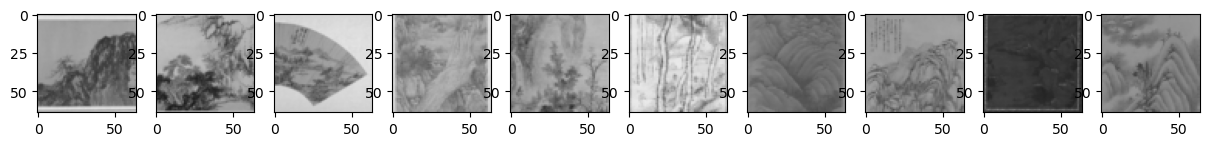

In [17]:
img_indices = [i for i in range(10)]
images = ds.getbatch(img_indices)
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
    axs[i].imshow(img.cpu().permute(1, 2, 0))

In [18]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())
  # return torch.log(image)/torch.log(image.max())

In [19]:
x = images
x = x.cuda()
# we want the gradient of the input x
# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
x.requires_grad_()
loss = trainer.model(x)
loss = loss / trainer.gradient_accumulate_every

In [20]:
# backward function on loss performs the backward pass in the computation graph and calculates the gradient of 
# loss with respect to nodes in the computation graph

loss.backward()

In [21]:
'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''

saliencies, _ = torch.max(x.grad.data.abs().detach().cpu(),dim=1)
saliencies = torch.stack([normalize(item) for item in saliencies])

In [22]:
xai_painting_results_folder = Path('./xai_painting_results_folder/')
xai_painting_results_folder.mkdir(exist_ok = True)

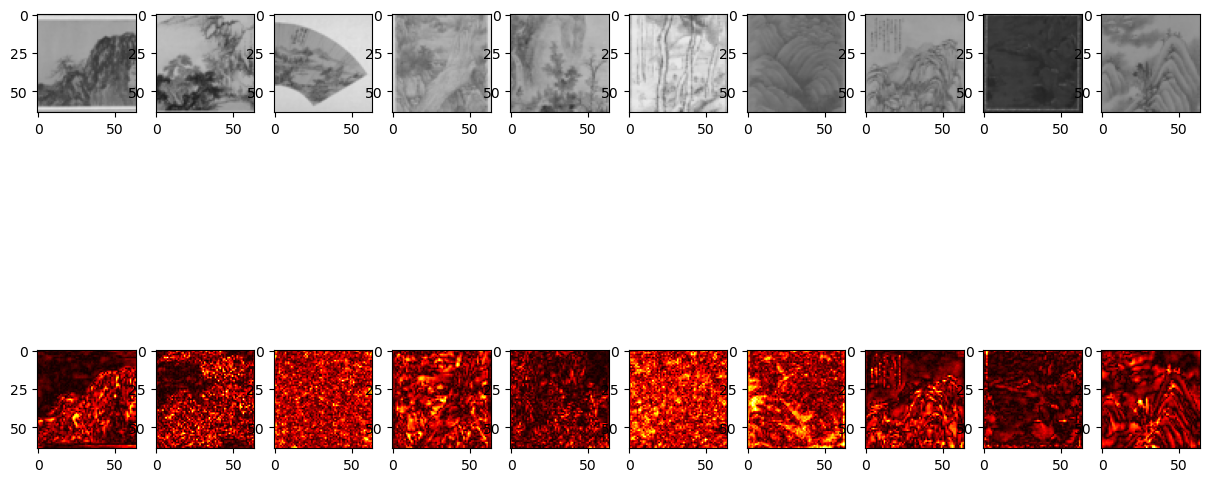

In [23]:
# visualize
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
  for column, img in enumerate(target):
    if row==0:
      axs[row][column].imshow(img.permute(1, 2, 0).numpy())
      # What is permute?
      # In pytorch, the meaning of each dimension of image tensor is (channels, height, width)
      # In matplotlib, the meaning of each dimension of image tensor is (height, width, channels)
      # permute is a tool for permuting dimensions of tensors
      # For example, img.permute(1, 2, 0) means that,
      # - 0 dimension is the 1 dimension of the original tensor, which is height
      # - 1 dimension is the 2 dimension of the original tensor, which is width
      # - 2 dimension is the 0 dimension of the original tensor, which is channels
    else:
      axs[row][column].imshow(img.numpy(), cmap=plt.cm.hot)
      torchvision.utils.save_image(img, f'{xai_painting_results_folder}/sample-{column}.jpg')

plt.show()
plt.close()

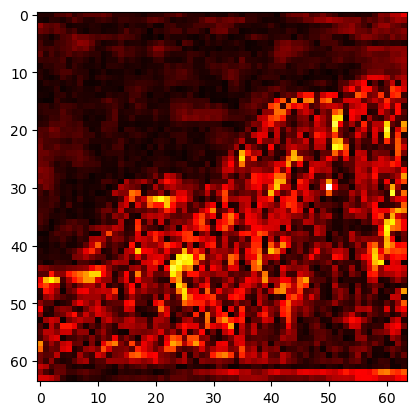

In [24]:
plt.imshow(saliencies[0].numpy(), cmap=plt.cm.hot)

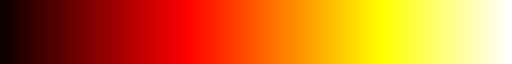

In [25]:
plt.cm.hot